In [3]:
import pandas as pd
import scipy
from scipy import special
from scipy import stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import pingouin as pg
from datetime import datetime
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)


In [4]:
#Выгрузим данные сразу и распарсим даты😎
customers = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-ananin/Данные Пром.проект/olist_customers_dataset.csv')
orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-ananin/Данные Пром.проект/olist_orders_dataset.csv', parse_dates = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
items = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-ananin/Данные Пром.проект/olist_order_items_dataset.csv', parse_dates = ['shipping_limit_date'])

In [5]:
#Убедимся в наличии и отсутсвии NULL в разных колонках.
#orders_customers.isna().sum()
#order_approved_at                14
#order_delivered_carrier_date      2
#order_delivered_customer_date     8

orders_customers = orders.merge(customers, how = 'inner', on = 'customer_id')

orders_customers = orders_customers.query('order_status == "delivered"')

orders_customers = orders_customers.groupby('customer_unique_id')

orders_customers.customer_unique_id.nunique().to_frame()

#За совершенную покупку беру только "delivered", т.к. на любом другом этапе покупка в теории может быть отменена и потеряна
#1.Ответ: 93358🤔

,customer_unique_id
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,1
0000b849f77a49e4a4ce2b2a4ca5be3f,1
0000f46a3911fa3c0805444483337064,1
0000f6ccb0745a6a4b88665a16c9f078,1
0004aac84e0df4da2b147fca70cf8255,1
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1
fffea47cd6d3cc0a88bd621562a9d061,1
ffff371b4d645b6ecea244b27531430a,1


In [41]:
#2. 
#Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?
#unavailable —  недоступен
#canceled —  отменён

In [6]:
#Выделяем причины проблем с заказами за весь период наблюдений
order_cancel = orders.query('order_status == "canceled"')
order_unavailable = orders.query('order_status == "unavailable"')

#Есть 3 основные причины: Отмена (~620), Недоступность (~600) и 
#прерывание оформления (заказ создан, но не оплачен — order_approved_at == NaN = 14)

In [7]:
order_cancel_month = order_cancel['order_purchase_timestamp'].dt.strftime('order_purchase_timestamp : %m')

order_cancel_month = order_cancel_month.groupby(order_cancel_month).count()

#Подсчитываем общее количество отмененных заказов
total_cancelled_orders = order_cancel_month.sum()

#Подсчитываем количество месяцев, за которые у нас есть данные
num_months = len(order_cancel_month)

#Считаем среднее количество отмененных заказов за все месяцы
avg_cancelled_orders_per_month = total_cancelled_orders / num_months
avg_cancelled_orders_per_month

#Ответ: 52.083333333333336 отмен заказов в месяц

52.083333333333336

In [8]:
order_unavailable_month = order_unavailable['order_purchase_timestamp'].dt.strftime('order_purchase_timestamp : %m')

order_unavailable_month = order_unavailable_month.groupby(order_unavailable_month).count()

#Подсчитываем общее количество отмененных заказов
total_unavailable_orders = order_unavailable_month.sum()

#Подсчитываем количество месяцев, за которые у нас есть данные
num_months_unavailable = len(order_unavailable_month) #В распоряжении ГОД

#Считаем среднее количество отмененных заказов за все месяцы
avg_order_unavailable_per_month = total_unavailable_orders / num_months_unavailable
avg_order_unavailable_per_month

#Ответ: 50.75 недоступных заказа месяц

50.75

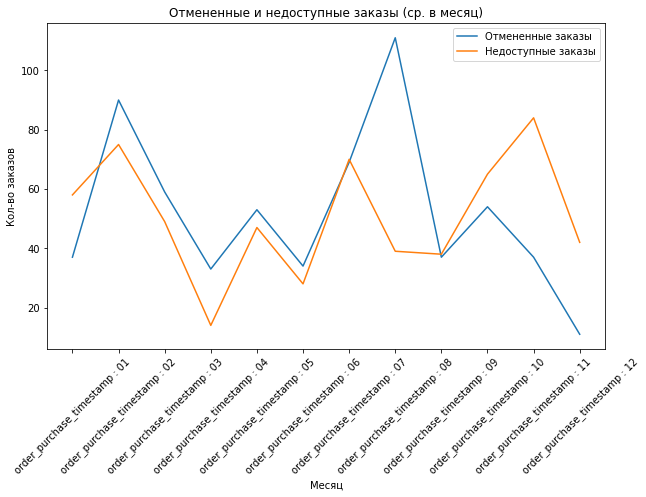

In [9]:
#Продемонстрируем более наглядно🤓
plt.figure(figsize=(10, 6))
plt.plot(order_cancel_month.index, order_cancel_month.values, label='Отмененные заказы')
plt.plot(order_unavailable_month.index, order_unavailable_month.values, label='Недоступные заказы')
plt.title('Отмененные и недоступные заказы (ср. в месяц)')
plt.xlabel('Месяц')
plt.ylabel('Кол-во заказов')
plt.legend()
plt.xticks(rotation=45)
plt.show()
#На графике видно, что динамика недоступных и отмененных заказов по месяцам похожи, 
#однако летом заказы чаще отменяются, нежели недоступны. Осенью недоступных заказов больше чем летом.

In [10]:
#3. 
#По каждому товару определить, в какой день недели товар чаще всего покупается.
merged = pd.merge(orders, items, on='order_id')

#Преобразование столбца order_purchase_timestamp в формат datetime
merged['order_purchase_timestamp'] = pd.to_datetime(merged['order_purchase_timestamp'])

#Получение дня недели для каждой продажи
merged['weekday'] = merged['order_purchase_timestamp'].dt.weekday

#Подсчет количества продаж
product_weekday_sales = merged.groupby(['product_id', 'weekday'])['order_item_id'].count()

#Получение дня недели
most_common_weekday = product_weekday_sales.groupby('product_id').idxmax().apply(lambda x: x[1])
most_common_weekday.to_frame()
#Ответ:^👆

,order_item_id
product_id,
00066f42aeeb9f3007548bb9d3f33c38,6
00088930e925c41fd95ebfe695fd2655,1
0009406fd7479715e4bef61dd91f2462,3
000b8f95fcb9e0096488278317764d19,2
000d9be29b5207b54e86aa1b1ac54872,1
...,...
fff6177642830a9a94a0f2cba5e476d1,5
fff81cc3158d2725c0655ab9ba0f712c,0
fff9553ac224cec9d15d49f5a263411f,4


In [ ]:
#4. 
#Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?
#Не стоит забывать, что внутри месяца может быть не целое количество недель. 
#Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [100]:
#order_approved_at —  время подтверждения оплаты заказа — берем за факт "покупка"


In [11]:
#Соединим датафреймы для начала👉👈
customers_orders = customers.merge(orders, on = 'customer_id')

#Выделим необходимые нам участки даты
customers_orders['week'] = customers_orders['order_purchase_timestamp'].dt.week
customers_orders['month'] = customers_orders['order_purchase_timestamp'].dt.month

#Группировка заказов по уникальному идентификатору покупателя и номеру недели
orders_per_customer_per_week = customers_orders.groupby(['customer_unique_id', 'month', 'week']).size().reset_index(name='order_count')

#Группировка заказов по месяцам, посчитаем среднее и выбросим дубликаты🚯
average_orders_per_week = orders_per_customer_per_week.groupby(['customer_unique_id', 'month'])['order_count'].mean().reset_index(name='average_orders')
average_orders_per_week.drop_duplicates()
#Вот ☝ датафрейм с ответом на вопрос. Далее продемонстрирую нагляднее.

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


,customer_unique_id,month,average_orders
0,0000366f3b9a7992bf8c76cfdf3221e2,5,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,5,1.0
2,0000f46a3911fa3c0805444483337064,3,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,10,1.0
4,0004aac84e0df4da2b147fca70cf8255,11,1.0
...,...,...,...
97996,fffcf5a5ff07b0908bd4e2dbc735a684,6,1.0
97997,fffea47cd6d3cc0a88bd621562a9d061,12,1.0
97998,ffff371b4d645b6ecea244b27531430a,2,1.0
97999,ffff5962728ec6157033ef9805bacc48,5,1.0


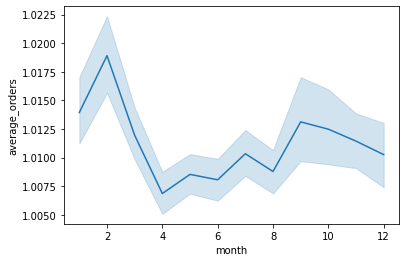

In [12]:
#Для наглядности продемонстрируем на графике👀
sns.lineplot(data = average_orders_per_week, x = 'month', y = 'average_orders')
#По всей видимости пользователи совершают в среднем примерно 1-2 покупки в неделю втечение любого месяца🤔🤔🤔

In [ ]:
#5.
#Используя pandas, проведи когортный анализ пользователей. 
#В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

In [13]:
#Для удобства я вновь соединю датасеты и создам ключевую колонку cohort_month😎
#Воспользуюсь уже созданным ранее датафреймом для манипуляций колонкой с уникальными ID пользователей
customers_orders = customers.merge(orders, on='customer_id')
customers_orders['order_month'] = customers_orders.order_purchase_timestamp.dt.to_period('M')
customers_orders['cohort_month'] = customers_orders.groupby('customer_unique_id')['order_month'].transform('min')

#Создам столбец order_period
#Ради вычислительных операций преобразуем order_month и cohort_month в численный тип
customers_orders['order_period'] = (customers_orders.order_month.astype('int') - customers_orders.cohort_month.astype('int'))

#Создание когорт и подсчет количества уникальных пользователей
cohorts = customers_orders.groupby(['cohort_month', 'order_period']).agg({'customer_unique_id': 'nunique'}).reset_index()

#Расчет retention rate
cohorts['retention'] = cohorts['customer_unique_id'].div(cohorts.groupby('cohort_month')['customer_unique_id'].transform('first'))

#Фильтрация и нахождение когорты с самым высоким retention на 3-й месяц
retention_3rd_month = cohorts[cohorts['order_period'] == 3]
highest_retention_cohort = retention_3rd_month[retention_3rd_month['retention'] == retention_3rd_month['retention'].max()]
#highest_retention_cohort
#Ответ:^☝ 0.004141

In [ ]:
#6
#Часто для качественного анализа аудитории использую подходы, основанные на сегментации. 
#Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 
#В кластеризации можешь выбрать следующие метрики: 
#R - время от последней покупки пользователя до текущей даты, 
#F - суммарное количество покупок у пользователя за всё время, 
#M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. 
#Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.
#Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней,
#frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

In [14]:
# Объединение таблиц снова, но уже всех вместе👉👈
customers_orders = customers_orders.merge(items, on='order_id')

# Организуем столбец с датой/временем
customers_orders['order_purchase_timestamp'] = pd.to_datetime(customers_orders['order_purchase_timestamp'])

# Расчет метрик RFM
today = datetime.now()
recency = customers_orders.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
recency['recency'] = (today - recency['order_purchase_timestamp']).dt.days
frequency = customers_orders.groupby('customer_unique_id')['order_id'].nunique().reset_index()
frequency.rename(columns={'order_id': 'frequency'}, inplace=True)
monetary = customers_orders.groupby('customer_unique_id')['price'].sum().reset_index()
monetary.rename(columns={'price': 'monetary'}, inplace=True)

# Объединение метрик
rfm = recency.merge(frequency, on='customer_unique_id')
rfm = rfm.merge(monetary, on='customer_unique_id')

# Стандартизация данных
rfm_scaled = (rfm[['recency', 'frequency', 'monetary']] - rfm[['recency', 'frequency', 'monetary']].mean()) / rfm[['recency', 'frequency', 'monetary']].std()

# Количество кластеров
k = 4 
random.seed(42)
centroids = random.permutation(rfm_scaled.shape[0])[:k]
kmeans_labels = np.argmin(np.linalg.norm(rfm_scaled.values[:, None] - rfm_scaled.values[centroids], axis=-1), axis=-1)

# Добавление метки в данные RFM
rfm['cluster'] = kmeans_labels

# Расчет границ метрик для каждого кластера
cluster_bounds = rfm.groupby('cluster').agg({'recency': ['min', 'max'], 'frequency': ['min', 'max'], 'monetary': ['min', 'max']})

# Вывод метрик для каждой группы🤔
for cluster, bounds in cluster_bounds.iterrows():
    recency_min, recency_max = bounds['recency']['min'], bounds['recency']['max']
    frequency_min, frequency_max = bounds['frequency']['min'], bounds['frequency']['max']
    monetary_min, monetary_max = bounds['monetary']['min'], bounds['monetary']['max']

RFM-сегмент 0: Recency от 1955.0 до 2449.0 дней, Frequency от 1.0 до 6.0 заказов, Monetary от 2.29 до 1049.0 рублей.
RFM-сегмент 1: Recency от 1726.0 до 1984.0 дней, Frequency от 1.0 до 3.0 заказов, Monetary от 0.85 до 193.0 рублей.
RFM-сегмент 2: Recency от 1721.0 до 2279.0 дней, Frequency от 1.0 до 16.0 заказов, Monetary от 76.0 до 1140.9 рублей.
RFM-сегмент 3: Recency от 1729.0 до 2419.0 дней, Frequency от 1.0 до 5.0 заказов, Monetary от 1090.0 до 13440.0 рублей.


In [ ]:
#Ответ: recency_min, recency_max, frequency_min, frequency_max, monetary_min, monetary_max